# Modulation-Classification

Developing AutoML Model for RadioML Dataset for Modulation Classification. SNR Ratio's(in dB) of Channel are $[−20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18]$.

**Data**: RadioML Dataset

**Modulation Classification:**
We will use AutoML to create a Classifier to Predict Labels.

## Imports


### GPU Information

The following GPU is used while Training the Model. Google Colab is used for Training so the GPU might change while running it later.

**GPU-Specifications:**
*   Name: Tesla P100
*   GPU Memory: 16280MiB

In [1]:
!nvidia-smi

Thu Sep  2 19:14:54 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Importing Data

Files are uploaded in Google Drive. Notebook is connected to Google Drive

In [2]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My\ Drive/Modulation-Classification/RadioML-Dataset/AutoML

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/Modulation-Classification/RadioML-Dataset/AutoML


### Importing Libraries

We will be using AutoKeras for generating AutoML Models.
Source of Documentation: [https://autokeras.com/](https://autokeras.com/)

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as pimg
import seaborn as sns
import scipy.io
import os
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# AutoML Libraries
!pip3 install autokeras==1.0.12
!pip3 install tensorflow==2.4
!pip3 install keras-tuner==1.0.2
import autokeras as ak

# Tensorflow Libraries
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, ReLU, Conv2D, Input, MaxPooling2D, BatchNormalization, AveragePooling2D, Reshape, ZeroPadding2D, Dropout
from tensorflow.keras.models import Model

## Customised AutoML Blocks

In [4]:
class ReshapeLayerBlock(ak.Block):
    def build(self, hp, inputs=None):
        input_node = inputs[0]
        dims = input_node.shape.as_list()[1:]
        output_node = tf.keras.layers.Reshape((dims[0],dims[1]*dims[2]))(input_node)
        return output_node

class AddDimsLayerBlock(ak.Block):
    def build(self, hp, inputs=None):
        input_node = inputs[0]
        output_node = tf.expand_dims(input_node,axis=1)
        return output_node

class PermuteLayerBlock(ak.Block):
    def build(self, hp, shape=None, inputs=None):
        input_node = inputs[0]
        dims = len(input_node.shape.as_list()[1:])
        output_node = tf.keras.layers.Permute([*range(dims,0,-1)])(input_node)
        return output_node

Callbacks

In [5]:
EarlyStoppingCallbacks = [tf.keras.callbacks.EarlyStopping(patience=5)]

## AutoML ResNet Model Training for Clean Data

### Importing Data

In [6]:
# Loading Training Data
Clean_X_Train = np.load("../Data/Clean-Data/Clean_X_Train.npy")
Clean_y_Train = np.load("../Data/Clean-Data/Clean_y_Train.npy")

### AutoML Model

Creating Classifier

**Note:** Loss should be carefully monitered as Model is not converging easily and gets stuck at Training Loss = 2.39.

In [7]:
tf.keras.backend.clear_session()

input_node = ak.Input()
addDims_node = AddDimsLayerBlock()(input_node)
permute_node = PermuteLayerBlock()(addDims_node)
resnet_node = ak.ResNetBlock(pretrained=False)(permute_node)
dense_node = ak.DenseBlock()(resnet_node)
output_node = ak.ClassificationHead(num_classes=11,
                                    loss='categorical_crossentropy')(dense_node)

RadioMLClassifier = ak.AutoModel(inputs=input_node,
                                outputs=output_node,
                                overwrite=True,
                                tuner='greedy',
                                max_trials=3,
                                project_name="ResNet_Model/0")

RadioMLClassifier.fit(Clean_X_Train, Clean_y_Train, epochs=10, steps_per_epoch=200, validation_split=0.05, shuffle=True)

Trial 3 Complete [00h 02m 58s]
val_loss: 17.536287307739258

Best val_loss So Far: 2.7534596920013428
Total elapsed time: 00h 09m 19s
INFO:tensorflow:Oracle triggered exit
Epoch 1/10
200/200 [==============================] - 16s 57ms/step - loss: 0.0837 - accuracy: 0.9716
Epoch 2/10
200/200 [==============================] - 11s 55ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3/10
200/200 [==============================] - 11s 55ms/step - loss: 0.4378 - accuracy: 0.9765
Epoch 4/10
200/200 [==============================] - 11s 55ms/step - loss: 1.3714e-04 - accuracy: 1.0000
Epoch 5/10
200/200 [==============================] - 11s 55ms/step - loss: 5.6210e-05 - accuracy: 1.0000
Epoch 6/10
200/200 [==============================] - 11s 55ms/step - loss: 0.8676 - accuracy: 0.9464
Epoch 7/10
200/200 [==============================] - 11s 55ms/step - loss: 1.2139e-06 - accuracy: 1.0000
Epoch 8/10
200/200 [==============================] - 11s 55ms/step - loss: 0.7366 - accuracy: 0.9

Exporting Model and Summary

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2, 128)]     0                                            
__________________________________________________________________________________________________
cast_to_float32 (CastToFloat32) (None, 2, 128)       0           input_1[0][0]                    
__________________________________________________________________________________________________
tf.expand_dims (TFOpLambda)     (None, 1, 2, 128)    0           cast_to_float32[0][0]            
__________________________________________________________________________________________________
permute (Permute)               (None, 128, 2, 1)    0           tf.expand_dims[0][0]             
______________________________________________________________________________________________

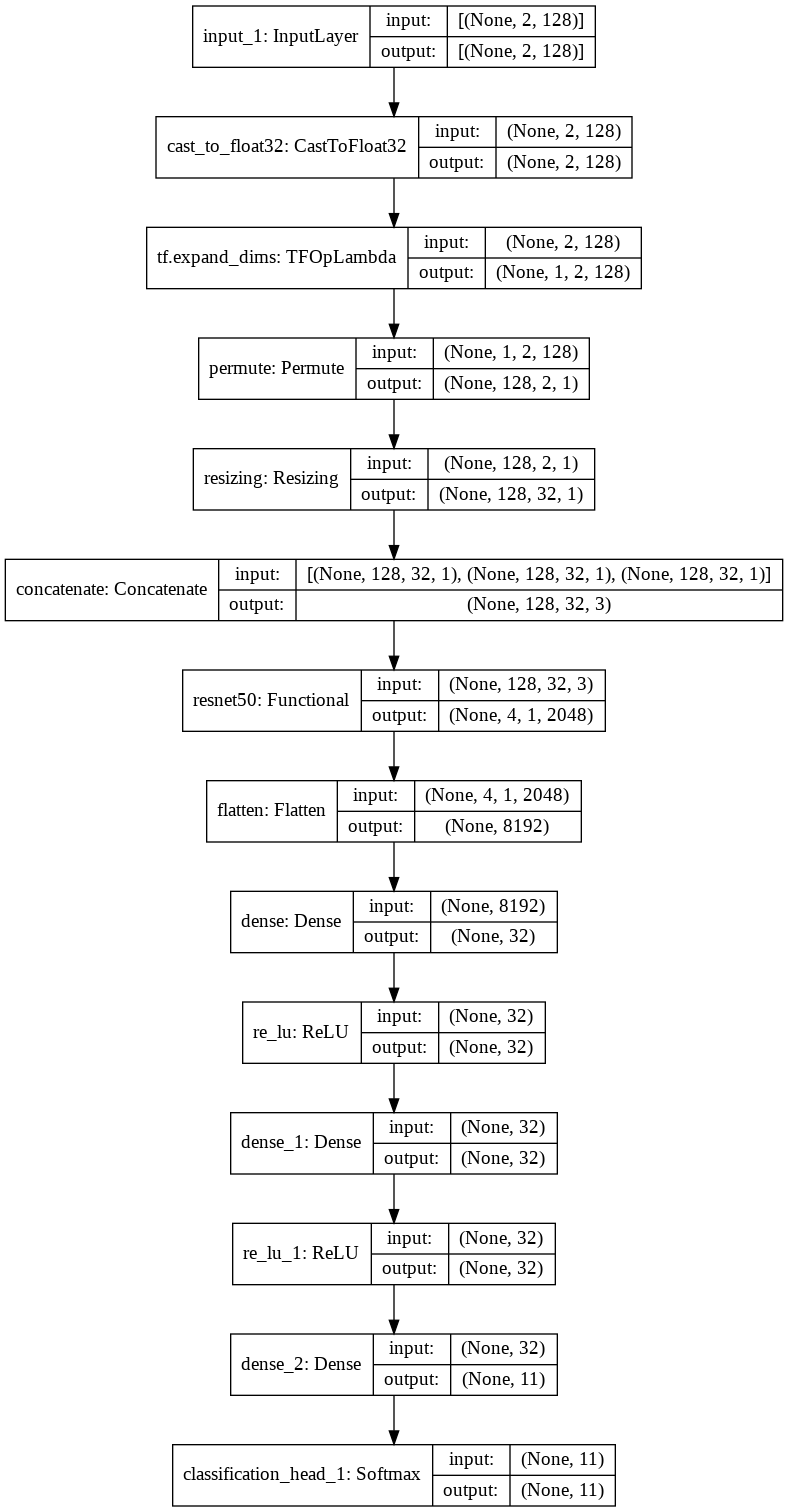

In [8]:
RadioML_Model = RadioMLClassifier.export_model()
RadioML_Model.summary()
tf.keras.backend.clear_session()
tf.keras.utils.plot_model(RadioML_Model, to_file='../Models/Clean_ResNet.png', show_shapes=True,show_layer_names=True)

Splitting Data

In [9]:
Clean_X_Train, Clean_X_Valid, Clean_y_Train, Clean_y_Valid = train_test_split(Clean_X_Train, Clean_y_Train, test_size=0.075, stratify=Clean_y_Train)

Training Model

In [10]:
RadioML_Model.fit(Clean_X_Train, Clean_y_Train, epochs=25, batch_size=1024, validation_data=(Clean_X_Valid,Clean_y_Valid), shuffle=True)

Epoch 1/25
159/159 [==============================] - 189s 1s/step - loss: 2.6330 - accuracy: 0.1613 - val_loss: 2.3756 - val_accuracy: 0.0965
Epoch 2/25
159/159 [==============================] - 165s 1s/step - loss: 1.7711 - accuracy: 0.3403 - val_loss: 1.8808 - val_accuracy: 0.3161
Epoch 3/25
159/159 [==============================] - 164s 1s/step - loss: 1.4152 - accuracy: 0.4559 - val_loss: 2.0697 - val_accuracy: 0.3055
Epoch 4/25
159/159 [==============================] - 165s 1s/step - loss: 1.2717 - accuracy: 0.4983 - val_loss: 1.3045 - val_accuracy: 0.4908
Epoch 5/25
159/159 [==============================] - 165s 1s/step - loss: 1.2392 - accuracy: 0.5155 - val_loss: 1.2698 - val_accuracy: 0.5073
Epoch 6/25
159/159 [==============================] - 164s 1s/step - loss: 1.2165 - accuracy: 0.5276 - val_loss: 1.7829 - val_accuracy: 0.4020
Epoch 7/25
159/159 [==============================] - 165s 1s/step - loss: 1.2224 - accuracy: 0.5273 - val_loss: 1.2478 - val_accuracy: 0.5189

Saving Model

In [11]:
RadioML_Model.save("../Models/Clean_ResNet.h5")